## Dichteverteilung der österreichischen Bruttogrundflächen

Die Zahlen zu BGF stammen von der letzten Registerzählung der Statistik Austria im Jahr 2011.
Die Flächen der bebauten Gundstücke sind in einer Studie der österreichischen Baulandreserven des UBA aus 2013 zusammengefasst.
Die Aggregationsebene ist in beiden Fällen der Bezirk.

761.0 mio m²


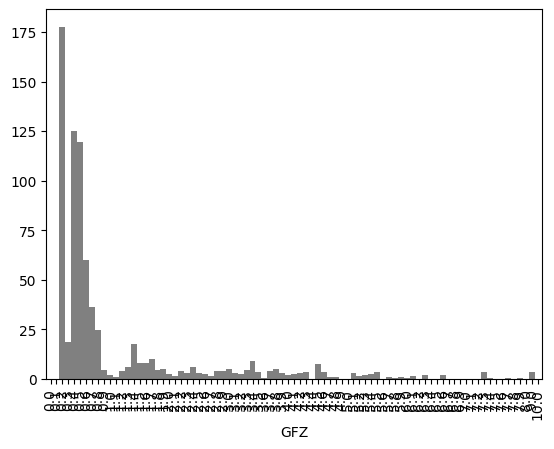

In [15]:
import sys
sys.path.append("../")
import pandas as pd

df = pd.read_excel("gfz_analysis.xlsx", sheet_name="python") # mio m2
df.index = df.GFZ
#df = df[df.index < 5.2]
ax = df.BGF.plot(kind="bar", width=1, color="grey")
print(df.BGF.sum().round(), "mio m²")


Festlegung der Gebäude-Typologien bzw Klassen hinsichtlich erreichbarer PE-Bilanz

In [16]:
from peexcel.utils.targets import target, Zielwert, ZQSynergy
from functools import partial

anteile = {
    "Unsaniert": dict(
        anteil=0.2,
        color="grey",
        zw=partial(target,
            A=-2,
            dx=0.15,
            EUI=40,
            cutoff=None,
            scale=1.)
    ),
    "Thermische Sanierung": dict(
        anteil=0.3,
        color="pink",
        zw=partial(target,
            A=-0.5,
            dx=0.15,
            EUI=35,
            cutoff=None,
            scale=1.)
    ),
    "NZEB Sanierung": dict(
        anteil=0.3,
        color="green",
        zw=partial(target,
                   A=10,
                   EUI=30,# gfzscale=0.7
                   )
    ),
    "PEQ Sanierung": dict(
        anteil=0.2,
        color="orange",
        zw=partial(target,
                   A=25,
                   EUI=30)
    ),
    "PEQ Neubau (ZQ AT)": dict(
        anteil=0.2,
        color="yellow",
        zw=partial(target,
                   EUI=30,
                   dx=0.18)
    ),
}

colors = [val["color"] for val in anteile.values()]

zw = pd.DataFrame(index=df.index)
peb = pd.DataFrame(index=df.index)

for key, val in anteile.items():
    df[key] = df.BGF * val["anteil"]
    zw[key] = val["zw"](df.index)
    peb[key] = df[key] * zw[key]
df

,GFZ,BGF,Unsaniert,Thermische Sanierung,NZEB Sanierung,PEQ Sanierung,PEQ Neubau (ZQ AT)
GFZ,,,,,,,
0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.1,0.1,0.000269,0.000054,0.000081,0.000081,0.000054,0.000054
0.2,0.2,177.683580,35.536716,53.305074,53.305074,35.536716,35.536716
0.3,0.3,18.426635,3.685327,5.527991,5.527991,3.685327,3.685327
0.4,0.4,125.265661,25.053132,37.579698,37.579698,25.053132,25.053132
...,...,...,...,...,...,...,...
7.8,7.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7.9,7.9,0.321167,0.064233,0.096350,0.096350,0.064233,0.064233
8.0,8.0,0.040299,0.008060,0.012090,0.012090,0.008060,0.008060


<Axes: xlabel='GFZ'>

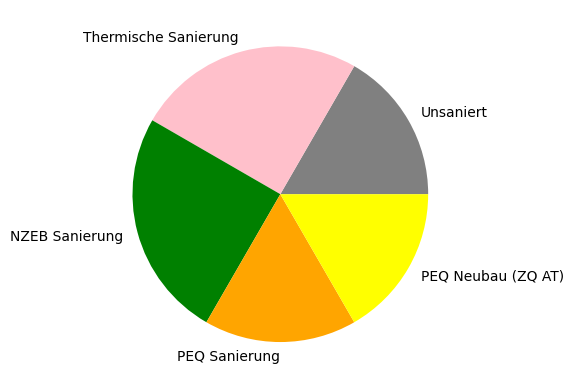

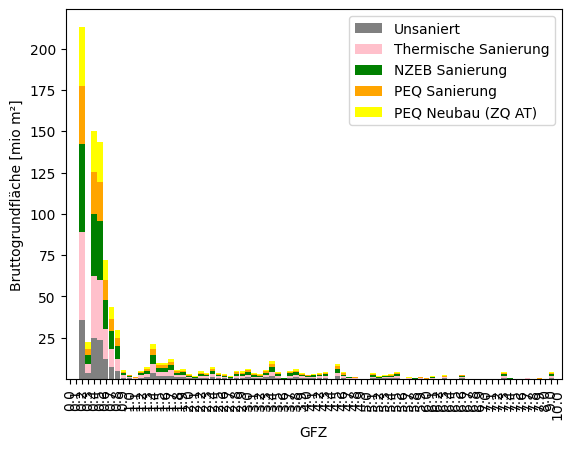

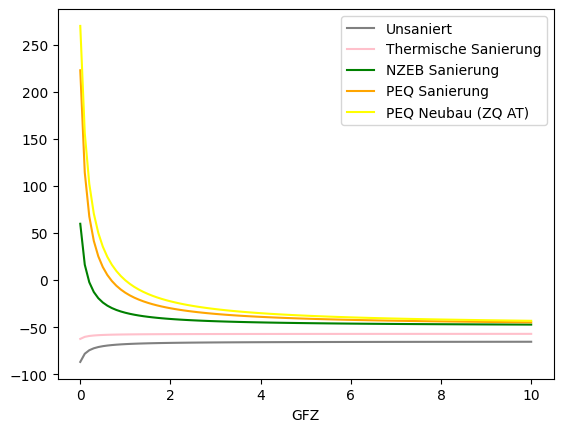

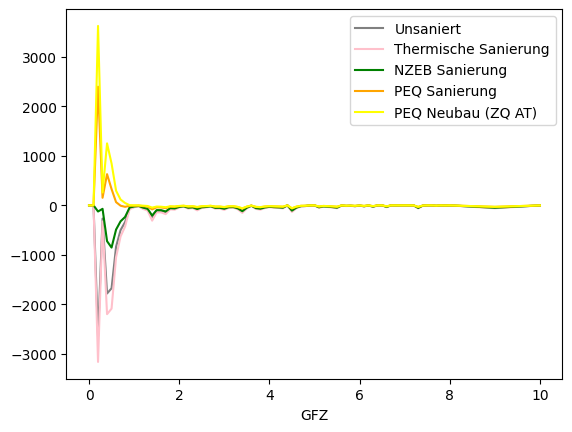

In [18]:
import matplotlib.pyplot as plt
#plots
df[list(anteile)].sum().plot(kind="pie", colors=colors)
plt.savefig("Anteile.png", dpi=300)
ax = df[list(anteile)].plot(kind="bar", stacked=True, width=0.95, color=colors)
plt.savefig("Histogram.png", dpi=300)
ax.set_ylabel("Bruttogrundfläche [mio m²]")

ax=zw[list(anteile)].plot(color=colors)

plt.savefig("Verteilung.png", dpi=300)

peb.plot(color=colors)

<Axes: xlabel='GFZ'>

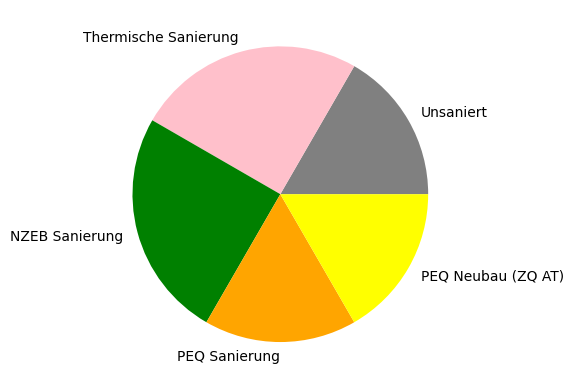

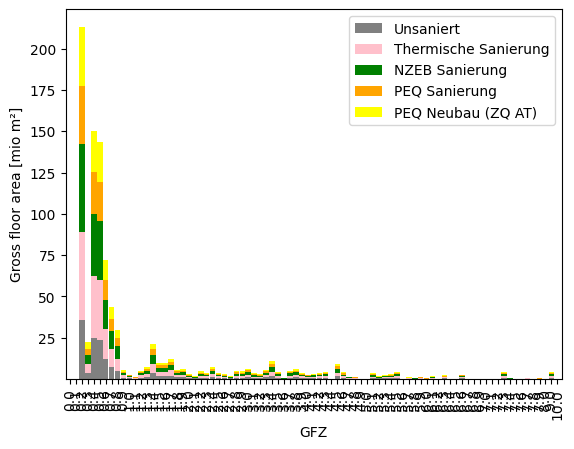

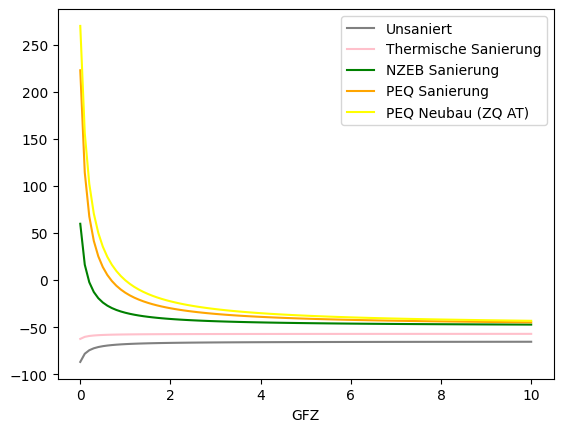

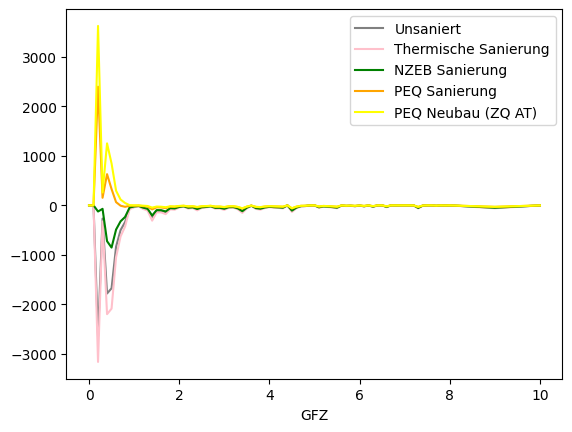

In [19]:
import matplotlib.pyplot as plt
#plots
anteile=list(anteile)

df[anteile].sum().plot(kind="pie", colors=colors)
plt.savefig("Anteile_en.png", dpi=300)
ax = df[anteile].plot(kind="bar", stacked=True, width=0.95, color=colors)
plt.savefig("Histogram_en.png", dpi=300)
ax.set_ylabel("Gross floor area [mio m²]")

ax=zw[anteile].plot(color=colors)

plt.savefig("Verteilung_en.png", dpi=300)

peb.plot(color=colors)

In [20]:
peb["Summe"] = peb.sum(axis=1)
summe = peb.sum() * 3.6
summe # kWh/m2 * mio m² = GWh/a * 3.6 = TJ/a

Unsaniert              -38490.112444
Thermische Sanierung   -47903.448985
NZEB Sanierung         -19244.999401
PEQ Sanierung            8088.589180
PEQ Neubau (ZQ AT)      19461.632942
Summe                  -78088.338707
dtype: float64

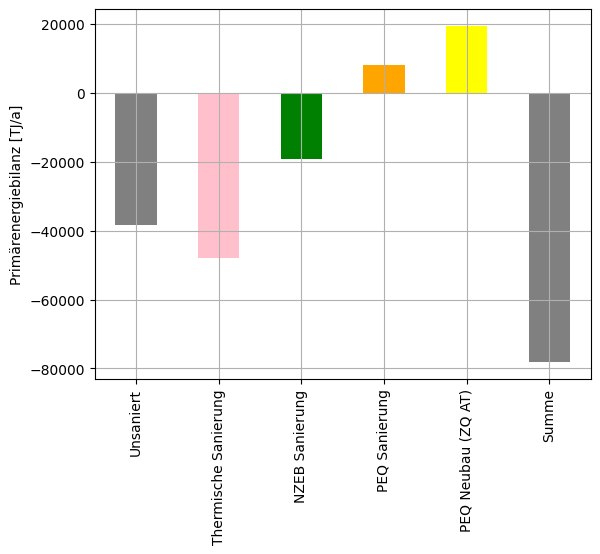

In [21]:
ax = summe.plot(kind="bar", color=colors, grid=True)
ax.set_ylabel("Primärenergiebilanz [TJ/a]")
kum = peb.cumsum(axis=0)

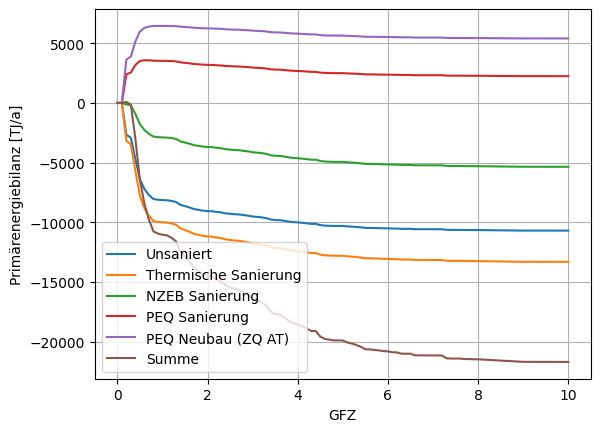

In [22]:
ax = kum.plot(grid=True)
ax.set_ylabel("Primärenergiebilanz [TJ/a]")

plt.savefig("PE_Bilanz.png", dpi=200)

In [ ]:
import peexcel.utils.nextcloud

file_path = "EE/6_Daten/Energie Österreich/Energiebilanzen_AT_1970-2020_Statistik_Austria.xlsx"
file = peexcel.utils.nextcloud.get(file_path)
df = pd.read_excel(file, sheet_name="Sektoraler Endverbrauch TJ")

In [ ]:
df.index =  df.Bereich

categories = [
    "Öffentliche und Private Dienstleistungen",
    "Private Haushalte",
    "Landwirtschaft",
    "Produzierender Bereich",
    "Verkehr"
]

In [ ]:
df.loc["Gebäude",:] = df.loc["Private Haushalte",:] + df.loc["Öffentliche und Private Dienstleistungen",:]
df.loc["Gebäude","Bereich"] = "Gebäude"
df.loc["Gebäude", 2011].round()

381595.0